# Building and deploying CNN models with Vertex AI pipelines: Challenge Lab

This Challenge Lab is recommended for students who have enrolled in the [**Learning Tensorflow**]() quest. You will be given a scenario and a set of tasks. Instead of following step-by-step instructions, you will use the skills learned from the labs in the quest to figure out how to complete the tasks on your own! An automated scoring system (shown on the Cloud Skills Boost lab instructions page) will provide feedback on whether you have completed your tasks correctly.

When you take a Challenge Lab, you will not be taught Google Cloud concepts. To build the solution to the challenge presented, use skills learned from the labs in the Quest this challenge lab is part of. You are expected to extend your learned skills and complete all the **`TODO:`** comments in this notebook.

Are you ready for the challenge?

## Scenario

You were recently hired as a Machine Learning Engineer for an Optical Character Recognition app development team. Your manager has tasked you with building a machine learning model to recognize Hiragana alphabets. The challenge: your business requirements are that you have just 6 weeks to produce a model that achieves great than 90% accuracy to improve upon an existing bootstrapped solution. Furthermore, after doing some exploratory analysis in your startup's data warehouse, you found that you only have a small dataset of 60k images of alphabets to build a higher-performing solution.

To build and deploy a high-performance machine learning model with limited data quickly, you will walk through training and deploying a CNN classifier for online predictions on Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai) platform. Vertex AI is Google Cloud's next-generation machine learning development platform where you can leverage the latest ML pre-built components to significantly enhance your development productivity, scale your workflow and decision-making with your data, and accelerate time to value.

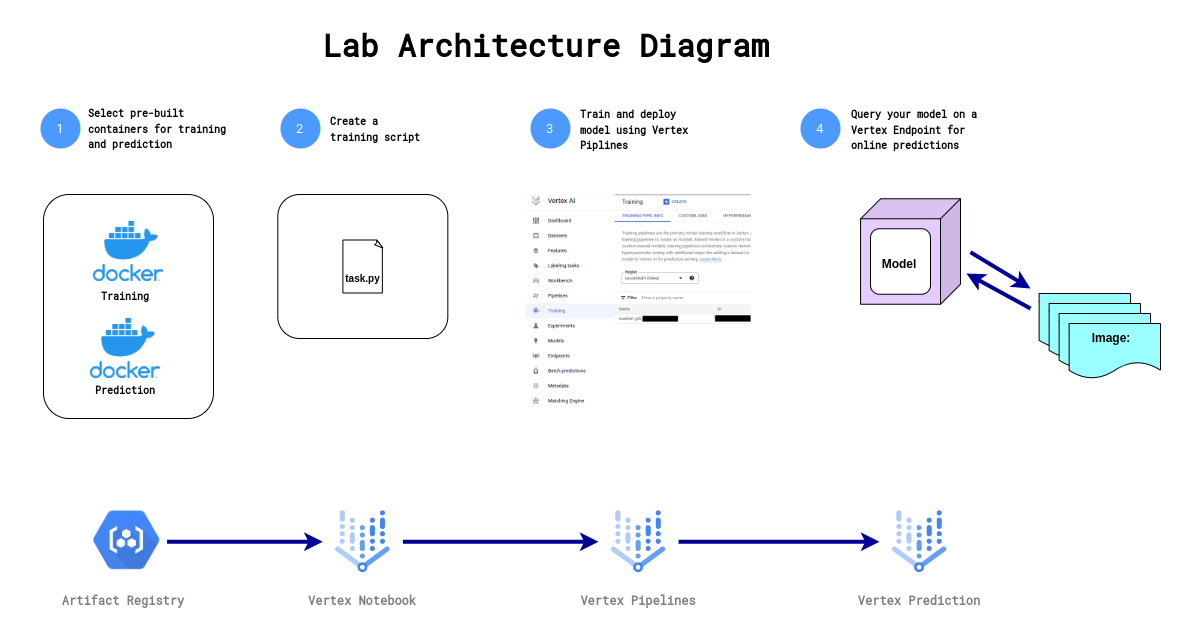

First, you will progress through a typical experimentation workflow where you will build your custom CNN model script using `tf.keras` classification layers. You will then send the model code to a custom training job and run the custom training job using pre-built containers provided by Vertex AI to run training and prediction. Lastly, you will deploy the model to an endpoint so that you can use your model for predictions.

## Learning objectives

* Train a model on Vertex AI using the SDK for Python.
* Deploy a custom image classification model for online prediction using Vertex AI.

## Setup

### Installation

In [ ]:
import os

In [ ]:
! pip3 install --user --upgrade google-cloud-aiplatform

Install the latest GA version of *google-cloud-storage* library as well.

In [ ]:
! pip3 install --user --upgrade google-cloud-storage

Install the *pillow* library for loading images.

In [ ]:
! pip3 install --user --upgrade pillow

Install the *numpy* library for manipulation of image data.

In [ ]:
! pip3 install --user --upgrade numpy

You can safely ignore errors during the numpy installation.

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. 

In [ ]:
import os

# Retrieve and set PROJECT_ID environment variables.
# TODO: fill in PROJECT_ID.

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    PROJECT_ID = ""

In [ ]:
PROJECT_ID

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
# TODO: Create a globally unique Google Cloud Storage bucket name for artifact storage.
# HINT: Start the name with gs://
BUCKET_NAME = ""

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

### Set up variables

Next, set up some variables used throughout the tutorial.

#### Import Vertex SDK for Python

Import the Vertex SDK for Python into your Python environment and initialize it.

In [ ]:
import os
import sys

from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

#### Set hardware accelerators

Here to run a container image on a CPU, we set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to `(None, None)` since this notebook is meant to be run in a Qwiklab environment where GPUs cannot be provisioned. 
  
Note: If you happen to be running this notebook from your personal GCP account, set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Tesla K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

In [ ]:
TRAIN_GPU, TRAIN_NGPU = (None, None)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Set pre-built containers

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


Here you will use pre-built containers provided by Vertex AI to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [ ]:
TRAIN_VERSION = "tf-cpu.2-8"
DEPLOY_VERSION = "tf2-cpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

#### Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [ ]:
MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

### Training script

In the next cell, you will write the contents of the training script, `task.py`.

In [ ]:
%%writefile task.py
# Training kmnist using CNN

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()

parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')

args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Define batch size
BATCH_SIZE = 32

# Load the dataset
datasets, info = tfds.load('kmnist', with_info=True, as_supervised=True)

# Normalize and batch process the dataset
ds_train = datasets['train'].map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y)).batch(BATCH_SIZE)


# Build the Convolutional Neural Network
model = tf.keras.models.Sequential([                               
      tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, input_shape=(28, 28, 1), padding = "same"),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu, padding = "same"),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      # TODO: Write the last layer.
      # Hint: KMNIST has 10 output classes.
      
    ])

model.compile(optimizer = tf.keras.optimizers.Adam(),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])



# Train and save the model

MODEL_DIR = os.getenv("AIP_MODEL_DIR")

model.fit(ds_train, epochs=args.epochs)

# TODO: Save your CNN classifier. 
# Hint: Save it to MODEL_DIR.

### Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they will be:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.

In [ ]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = "{}/{}".format(BUCKET_NAME, JOB_NAME)

EPOCHS = 5

CMDARGS = [
    "--epochs=" + str(EPOCHS),
]

### Train the model

Define your custom training job on Vertex AI.

In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    requirements=["tensorflow_datasets==4.6.0"],
    # TODO: fill in the remaining arguments for the CustomTrainingJob function.
)

MODEL_DISPLAY_NAME = "kmnist-" + TIMESTAMP

# Start the training
model = job.run(
    model_display_name=MODEL_DISPLAY_NAME,
    replica_count=1,
    accelerator_count=0,
    # TODO: fill in the remaining arguments to run the custom training job function.
)

## Deploy the model

Before you use your model to make predictions, you need to deploy it to an `Endpoint`. You can do this by calling the `deploy` function on the `Model` resource.

In [ ]:
DEPLOYED_NAME = "kmnist_deployed-" + TIMESTAMP

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        accelerator_type=None,
        accelerator_count=0,
        # TODO: fill in the remaining arguments to deploy the model to an endpoint.
    )

## Make an online prediction request

Send an online prediction request to your deployed model.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

tfds.disable_progress_bar()

In [ ]:
datasets, info = tfds.load('kmnist', batch_size=-1, with_info=True, as_supervised=True)

test_dataset = datasets['test']

In [ ]:
x_test, y_test = tfds.as_numpy(test_dataset)

# Normalize (rescale) the pixel data by dividing each pixel by 255. 
x_test = x_test.astype('float32') / 255.
x_test.shape, y_test.shape

In [ ]:
#@title Pick the number of test images
NUM_TEST_IMAGES = 20 #@param {type:"slider", min:1, max:20, step:1}
x_test, y_test = x_test[:NUM_TEST_IMAGES], y_test[:NUM_TEST_IMAGES]

### Send the prediction request

Logging module added to log the prediction result

In [ ]:
# Import and configure logging
from google.cloud import logging
logging_client = logging.Client()
logger = logging_client.logger('challenge-notebook')

Now that you have test images, you can use them to send a prediction request.

In [ ]:
# TODO: use your Endpoint to return prediction for your x_test.

predictions = 


In [ ]:
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test.tolist()))
total = len(y_predicted)

logger.log_text(str(correct/total))

print(
    f"Correct predictions = {correct}, Total predictions = {total}, Accuracy = {correct/total}"
)